#**Машинное обучение ИБ-2024**

#**Домашнее задание 2.**
#Классификация, KNN, LogReg, SVC.

In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## **Теоретическая Часть**

Мы рассматриваем задачу бинарной классификации. Для прогнозирования мы хотели бы использовать модель логистической регрессии. Для регуляризации мы добавляем комбинацию штрафов в размере $l_2$ и $l_1$ (Elastic Net).

Каждый объект в обучающем наборе данных индексируется с помощью $i$ и описывается парой: объекты $x_i\in\mathbb{R}^{K}$ и двоичные метки $y_i$. Модель параметризуется со смещением $w_0\in\mathbb{R}$ и весами $w\in\mathbb{R}^K$.

Задача оптимизации в отношении $w_0, w$ заключается в следующем (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.



Градиенты функции потерь логистической регрессии представлены ниже:

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{1 + \exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{N}  \frac{y}{1 + \exp(y*(Xw+w_0)))}$$

#### 1. [0.5 Балл] Реализуйте функцию, выдающий значение функции потерь логичтической регрессии:

In [2]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
  X = np.array(X)
  y = np.array(y)
  N = X.shape[0]
  w = np.array(w)

  linear_comb = X @ w + w0

  logistic_loss = np.mean(np.log(1 + np.exp(-y * linear_comb)))

  l1_regularization = gamma * np.sum(np.abs(w))
  l2_regularization = beta * np.sum(w ** 2)

  total_loss = logistic_loss + l1_regularization + l2_regularization

  return total_loss



#### 2. [0.5 Балл] Реализуйте функцию, которая будет возвращать градиенты весов вашей модели Логистической регрессии:

In [3]:
def get_grad(X, y, w: List[float], w0: float, gamma =1., beta =1.) -> Tuple[List[float], float]:
  X = np.array(X)
  y = np.array(y)
  N = X.shape[0]
  w = np.array(w)

  linear_comb = X @ w + w0

  predictions = 1 / (1 + np.exp(-y * linear_comb))

  dw = -1/N * (X.T @ (y * (1 - predictions))) + gamma * np.sign(w) + 2 * beta * w
  dw0 = -1/N * np.sum(y * (1 - predictions))

  return dw.tolist(), dw0

In [4]:
# код для проверки

np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)

####  3. [1 Балл]  Реализуйте класс для модели логистической регрессии, используя выше написанные функции:

Модель должна обучаться методом SGD.

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [6]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state
        self.weights = None


    def fit(self, X, y):
        np.random.seed(self.random_state)
        m, n = X.shape
        self.weights = np.zeros(n)
        b = 0

        for _ in range(self.max_iter):
            for idx in range(m):
                random_index = np.random.randint(m)
                X_i = X[random_index:random_index+1]
                y_i = y[random_index:random_index+1]

                linear_model = np.dot(X_i, self.weights) + b
                y_predicted = self.sigmoid(linear_model)

                dw = (1 / m) * np.dot(X_i.T, (y_predicted - y_i))
                db = (1 / m) * np.sum(y_predicted - y_i)

                self.weights -= self.lr * (dw + (self.beta / m) * self.weights + (self.gamma / m) * np.sign(self.weights))
                b -= self.lr * db

            if np.linalg.norm(dw) < self.tolerance:
                break
        self.weights = np.append(self.weights, b)


    def predict(self, X):
        linear_model = np.dot(X, self.weights[:-1]) + self.weights[-1]
        y_predicted = self.sigmoid(linear_model)
        y_predicted_cls = [1 if i > 0.5 else 0 for i in y_predicted]
        return y_predicted_cls


    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights[:-1]) + self.weights[-1]
        y_predicted = self.sigmoid(linear_model)
        return np.array([1 - y_predicted, y_predicted]).T


In [ ]:
# этот код менять не надо!
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

####  4. [0.5 Балл]  Реализуйте функцию, которая отрисовывает объекты вашего датасета, их метки и разделяющую гиперплоскость, полученную от Логистической регрессии (пример того, что должно получиться ниже):

In [ ]:
def plot_decision_boundary(model, X, y):
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

  Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)

  plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Spectral)

  plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Spectral)

  plt.xlabel('Feature 1')
  plt.ylabel('Feature 2')
  plt.title('Decision Boundary')
  plt.show()


In [ ]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

AttributeError: 'Logit' object has no attribute 'sigmoid'

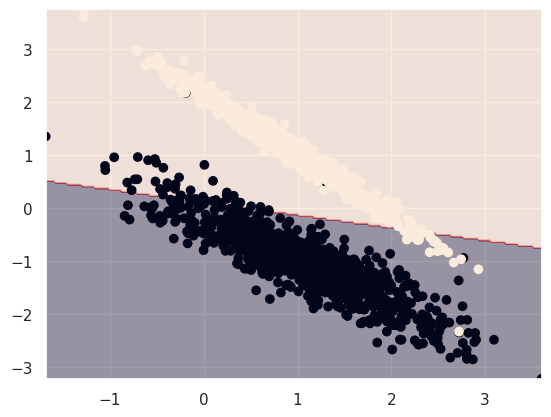

In [ ]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 Балл] Для предыдущей задачи отобразите на графике, как изменяется значение функция потерь от номера итерации.

In [ ]:
def plot_loss_history(model):
    plt.plot(model.loss_history, label='Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss vs. Iteration')
    plt.legend()
    plt.show()

In [ ]:
plot_loss_history(model)

AttributeError: 'Logit' object has no attribute 'loss_history'

#### 6. [2 Балл] Для данных, на которых тестировали модель Логистической регрессии, заиспользуйте модель SVC из библиотеки sklearn. Попробуйте различные ядра (kernel) и различные коэфициенты C. Посмотрите на метрики, которые мы обсуждали на занятии (Acc, Precision, Recall, AUC-ROC, F1-Score).

#### 7. [2 Балл] Реализуйте класс KNNClassifier, который должен реализовывать классификацию путем нахождения k ближайших соседей. В методе predict_proba Вам необходимо выдавать вектор вероятностей для каждого объекта, который означает, что объект является экземпляром i-го класса с p_i вероятностью. Протестируйте Ваш класс на данных, сгенерированных выше, посмотрите на метрики (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [ ]:
class KNNClassifier:
    def __init__(self, n_neighbors=5, metric='euclidean'):
      ...

    def fit(self, X, y):
      ...

    def predict(self, X):
      ...

    def predict_proba(self, X):
      ...

## **Практическая часть**

В этом задании мы будем работать с Датасетом Fashion Mnist. Это датасет, который представляет изображения одного канала с различными типами одежды. Вам необходимо провести полный пайплайн обучения моделей (KNN и Logreg), которые вы можете импортировать из библиотеки sklearn.

#### 8. [0 Балл] Импортируйте датафрейм из csv файла. Поделите выборку следующим образом - :50000 (Train) и 50000: (Test).

In [ ]:
df = pd.read_csv("/content/train.csv")
df

,Id,Category,Pixel000,Pixel001,Pixel002,Pixel003,Pixel004,Pixel005,Pixel006,Pixel007,...,Pixel774,Pixel775,Pixel776,Pixel777,Pixel778,Pixel779,Pixel780,Pixel781,Pixel782,Pixel783
0,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,6,0,0,0,0,0,0,0,5,...,0,0,0,30,43,0,0,0,0,0
3,3,0,0,0,0,1,2,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,4,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,59995,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,59996,1,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,59997,8,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,59998,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
train_df = df.iloc[:50000]
test_df = df.iloc[50000:]

In [ ]:
y = df['Category']
X = df.drop(columns = 'Category')

In [ ]:
X_train = train_df.drop(columns='Category')
y_train = train_df['Category']

# Разделение тестовой выборки на признаки и метки
X_test = test_df.drop(columns='Category')
y_test = test_df['Category']

#### 9. [0.5 Балл] Визуализируйте некоторые из объектов датасета. В колонках отображены яркости пикселей, которые представляют из себя изображения Fashion Mnist. С помощью matplotlib визуализируйте по одному представителю каждого класса.

KeyError: 3

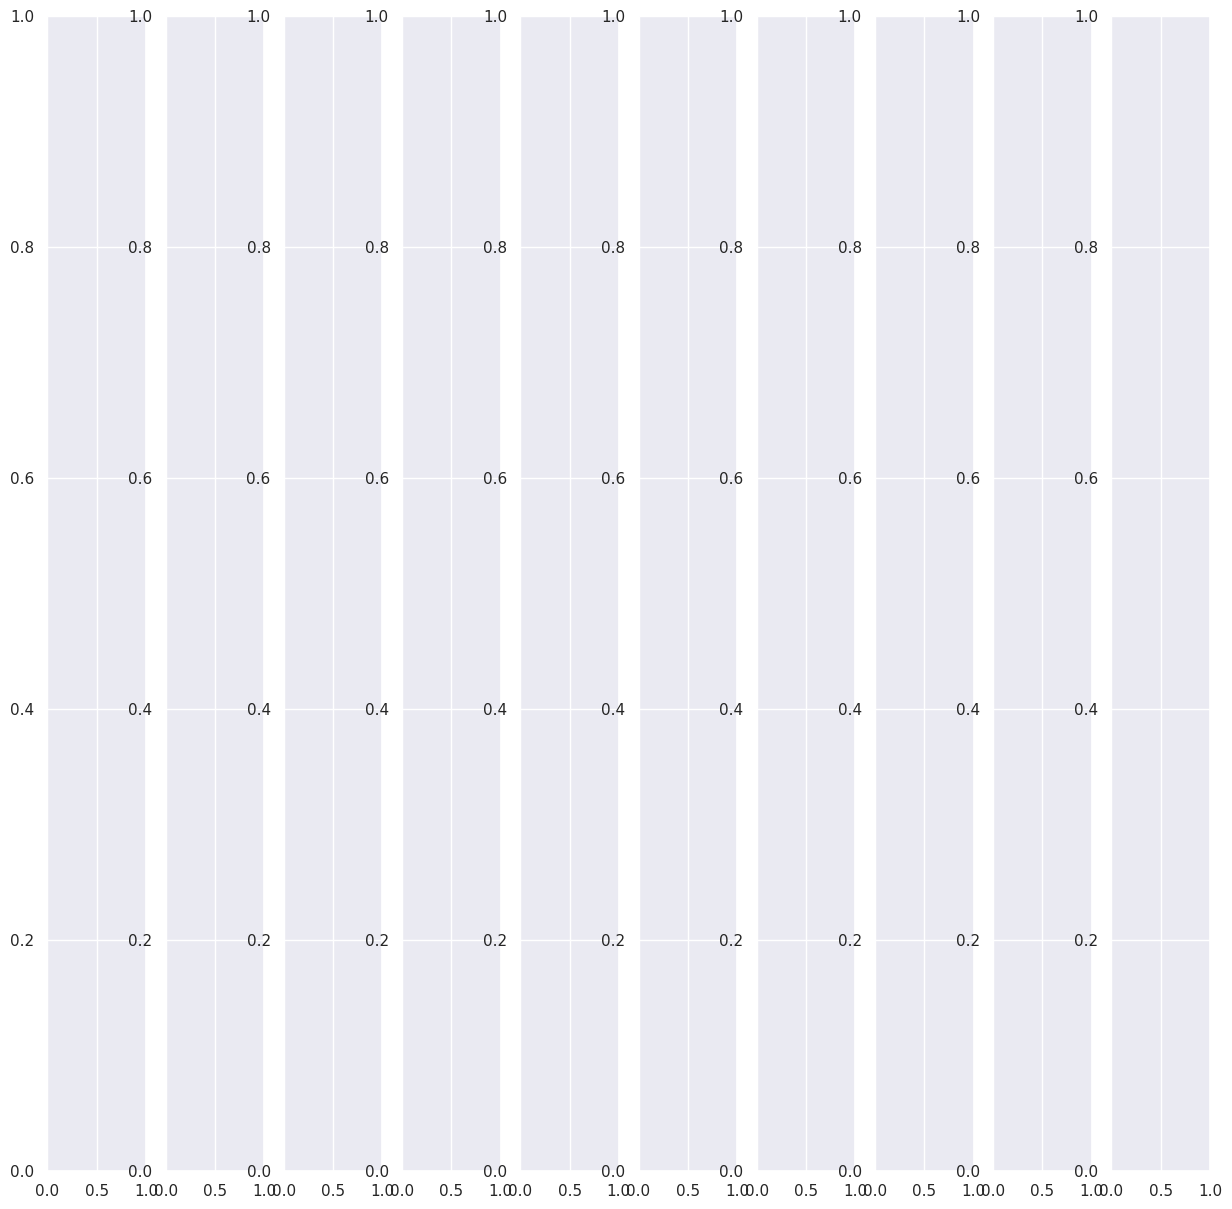

In [ ]:
unique_classes = np.unique(y_train)

fig, axes = plt.subplots(1, len(unique_classes), figsize=(15, 15))

for i, cls in enumerate(unique_classes):
    # Найти первый объект данного класса
    idx = np.where(y_train == cls)[0][0]
    image = X[idx].reshape(28, 28)  # Предположим, что изображения имеют размер 28x28

    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f'Class {cls}')
    axes[i].axis('off')

plt.show()

#### 10. [0.5 Балл] Отнормируйте признаки в датасете, попробуйте два варианта StandartScaller и MinMaxScaller.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
# Выход pca - numpy матрица, положим ее в новую переменную со всеми фичами
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### 10. [2 Балл] Проведите эксперименты: для моделей KNeighborsClassifier и LogisticRegression подберите гиперпараметры с помощью GridSerchCV (минимум 5 фолдов). Получите качество моделей на тестовой выборке. Основная метрика в данном задании будет accuracy. Сравните эти две модели. Какая модель показывает лучшее качество, предположите почему и напишите ответ.

**NB!**: в задании нужно подбирать несколько гиперпараметров по сетке. Какие гиперпараметры подбирать - решаете Вы сами. Обязательно обоснуйте, почему и какие параметры Вы подбираете! Например, подбор только гиперпараметра C в LogisticRegression не будет засчитываться как решение данного задания! Попытайтесь серьезно отнестись к нему, будто вы за это получите зарплату 300к.

## **Бонусы**

#### Задача 1. [1 Балл] У Вас есть датасет с 10**4 объектами. У всех объектов два признака и все они одинаковые у всех объектов. Однако, 5000 - отрицательного класса и 5000 - положительного класса. Вы запускате Логистическую регрессию для классификации на данном датасете. Что Вы получите в итоге обучения данной модели на SGD? Ответ обоснуйте.

Ответ: 1) Модель просто не сможет различить классы
2) Вероятность классов будет равной (это связано с тем, что лог рег предсказывает вероятность появления каждого класса, а т.к. признаки одинаковые, то вероятности будут совпадать. Так может получиться, что вероятность принадлежности к положительному классу будет равна 0.5, так как половина объектов относится к положительному классу, а половина — к отрицательному.

#### Задача 2. [1 Балл] При классификации Fashion Mnist модель Логистической регрессии на обучении многоклассовой классификации методом One-VS-All у Вас получилось k классификаторов. Изобразите веса ваших полученных моделей как изображения в matplotlib. Возможно, модель выучила какие-то графические паттерны в данных? Ответ обоснуйте.

#### Задача 3. [1 Балл] В задаче классификации Fashion Mnist Вы попытались выбить какой-то accuracy. Для получения бонусного балла Вам нужно на той же самой выборке получить значение метрики accuracy > 0.87 на тесте (Тестовую выборку менять нельзя, но обучающую можно). Какими моделями и методами Вы это будете делать - на Ваше усмотрение, но **нельзя использовать никакие нейронные сети**. Необходимо получить модель машинного обучения, выполняющую эту задачу.